In [1]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
jnp.set_printoptions(
    formatter={"float": "{:7.4f}".format}
)

In [2]:
def symmetric_gaussian(p, xcoords, ycoords):
    xc, yc, sigma, A, bg = p
    xdiff = xcoords - xc
    ydiff = ycoords - yc
    phi = xdiff**2 / (2 * sigma **2) + ydiff**2 / (2*sigma**2)
    return A * jnp.exp(-phi) + bg


In [3]:
boxsize = 13
xp = jnp.arange(-(boxsize-1) // 2, boxsize // 2 + 1)
yp = jnp.arange(-(boxsize-1) // 2, boxsize // 2 + 1)
xcoords, ycoords = jnp.meshgrid(xp, yp)
pars = [0.0, 0.0, 1.5, 50.0, 100.0]



In [4]:
G = symmetric_gaussian(pars, xcoords, ycoords)

In [5]:
for i in range(G.shape[0]):
    for j in range(G.shape[1]):
        print(f"{G[i,j]:6.3f} ", end="")
    print("\n", end="")

100.000 100.000 100.000 100.002 100.007 100.013 100.017 100.013 100.007 100.002 100.000 100.000 100.000 
100.000 100.001 100.006 100.026 100.079 100.155 100.193 100.155 100.079 100.026 100.006 100.001 100.000 
100.000 100.006 100.041 100.193 100.587 101.144 101.428 101.144 100.587 100.193 100.041 100.006 100.000 
100.002 100.026 100.193 100.916 102.782 105.418 106.767 105.418 102.782 100.916 100.193 100.026 100.002 
100.007 100.079 100.587 102.782 108.451 116.460 120.556 116.460 108.451 102.782 100.587 100.079 100.007 
100.013 100.155 101.144 105.418 116.460 132.059 140.037 132.059 116.460 105.418 101.144 100.155 100.013 
100.017 100.193 101.428 106.767 120.556 140.037 150.000 140.037 120.556 106.767 101.428 100.193 100.017 
100.013 100.155 101.144 105.418 116.460 132.059 140.037 132.059 116.460 105.418 101.144 100.155 100.013 
100.007 100.079 100.587 102.782 108.451 116.460 120.556 116.460 108.451 102.782 100.587 100.079 100.007 
100.002 100.026 100.193 100.916 102.782 105.418 106.767

In [6]:
J = jax.jacobian(symmetric_gaussian, argnums=0)

In [7]:
jacvals = jnp.array(J(pars, xcoords, ycoords))
jacvals = jacvals.reshape(5, -1).T

In [8]:
for i in range(jacvals.shape[0]):
    for j in range(jacvals.shape[1]):
        print(f"{jacvals[i,j]:7.4f} ", end="")
    print("\n", end="")

-0.0000 -0.0000  0.0001  0.0000  1.0000 
-0.0001 -0.0002  0.0012  0.0000  1.0000 
-0.0009 -0.0013  0.0074  0.0000  1.0000 
-0.0030 -0.0061  0.0303  0.0000  1.0000 
-0.0061 -0.0184  0.0817  0.0001  1.0000 
-0.0060 -0.0358  0.1472  0.0003  1.0000 
-0.0000 -0.0447  0.1789  0.0003  1.0000 
 0.0060 -0.0358  0.1472  0.0003  1.0000 
 0.0061 -0.0184  0.0817  0.0001  1.0000 
 0.0030 -0.0061  0.0303  0.0000  1.0000 
 0.0009 -0.0013  0.0074  0.0000  1.0000 
 0.0001 -0.0002  0.0012  0.0000  1.0000 
 0.0000 -0.0000  0.0001  0.0000  1.0000 
-0.0002 -0.0001  0.0012  0.0000  1.0000 
-0.0017 -0.0017  0.0111  0.0000  1.0000 
-0.0098 -0.0123  0.0671  0.0001  1.0000 
-0.0349 -0.0581  0.2635  0.0005  1.0000 
-0.0706 -0.1766  0.6828  0.0016  1.0000 
-0.0688 -0.3440  1.1924  0.0031  1.0000 
-0.0000 -0.4295  1.4318  0.0039  1.0000 
 0.0688 -0.3440  1.1924  0.0031  1.0000 
 0.0706 -0.1766  0.6828  0.0016  1.0000 
 0.0349 -0.0581  0.2635  0.0005  1.0000 
 0.0098 -0.0123  0.0671  0.0001  1.0000 
 0.0017 -0.0017 

float32


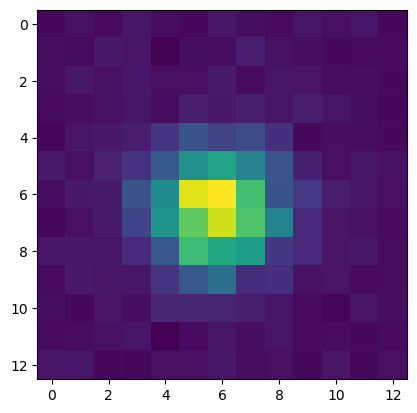

In [32]:
# load data
data = np.fromfile("../c_src/tests/mol01_13x13.bin", dtype=np.uint16).reshape(
    (13,13)
).astype(float)
data = jnp.array(data)
print(data.dtype)
plt.imshow(data)

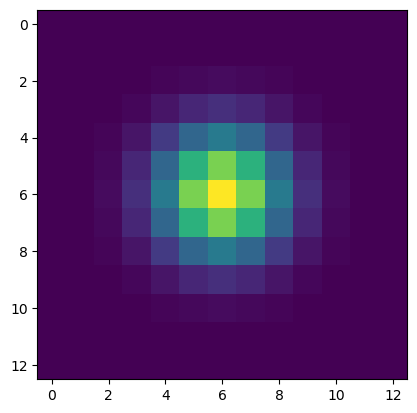

In [33]:
model = symmetric_gaussian(pars, xcoords, ycoords)
plt.imshow(model)

In [34]:
def objective_function(p, D, xcoords, ycoords):
    f = symmetric_gaussian(p, xcoords, ycoords)
    ratio = jnp.maximum(f, 1e-7) / jnp.maximum(D, 1e-7)
    return jnp.sum(f - D - D * jnp.log(ratio))

grad = jax.grad(objective_function, argnums=0)
hess = jax.jacrev(jax.jacfwd(objective_function, argnums=0), argnums=0)

In [35]:
objective_function(pars, data, xcoords, ycoords)

Array(787.5270, dtype=float32)

In [36]:
g = jnp.array(grad(pars, data, xcoords, ycoords))

In [37]:
g

Array([30.5608, -82.0825, -367.5539, -9.4707, -24.2962], dtype=float32)

In [38]:
hess_appx = jacvals.T @ jnp.diag(data.ravel() / model.ravel()**2) @ jacvals

In [39]:
hess_appx

Array([[51.6464, -0.4159, -4.8317, -0.1053, -0.2530],
       [-0.4159, 52.1083, 14.0173,  0.2698,  0.6859],
       [-4.8317, 14.0173, 198.9497,  3.1126, 11.5418],
       [-0.1053,  0.2698,  3.1126,  0.0975,  0.1873],
       [-0.2530,  0.6859, 11.5418,  0.1873,  1.8393]], dtype=float32)

In [40]:
H = jnp.array(hess(pars, data, xcoords, ycoords))

In [41]:
H

Array([[142.5896,  4.2322, -2.9259,  0.5059, -0.2530],
       [ 4.2322, 137.0479,  6.4360, -1.3718,  0.6859],
       [-2.9259,  6.4360, 364.3978, -4.2384, 11.5418],
       [ 0.5059, -1.3718, -4.2384,  0.0975,  0.1873],
       [-0.2530,  0.6859, 11.5418,  0.1873,  1.8393]], dtype=float32)

In [42]:
w = data / (model**2)

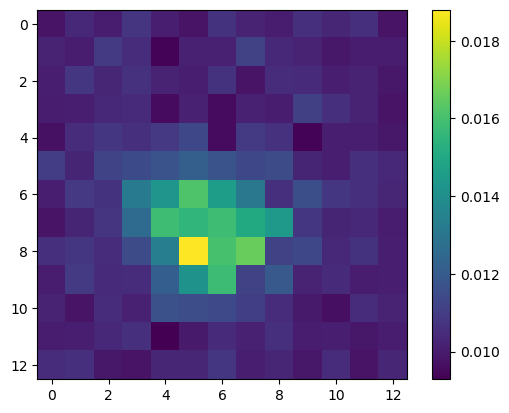

In [30]:
plt.imshow(w)
plt.colorbar()